# Non-Semantic Representation of Speech

- This notebook is a fork of https://www.kaggle.com/code/duythanhng/birdclef-2022-keras-simple-tutorial implementing mfcc features extraction + MobileNetV2 with Keras

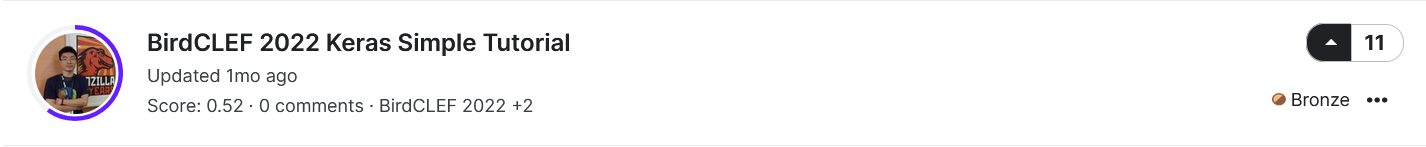

- Kaggle submission score of 0.52

- It aims to illustrate the use of Non-Semantic Representation of Speech with the implementation of TRILL model 
- Author: {Joel Shor, Aren Jansen, Ronnie Maor, Oran Lang, Omry Tuval, Félix de Chaumont Quitry, Marco Tagliasacchi, Ira Shavitt, Dotan Emanuel, Yinnon Haviv}
- Title: {Towards Learning a Universal Non-Semantic Representation of Speech}
- Year: 2020
- Ref: https://arxiv.org/pdf/2002.12764.pdf

# Import

In [ ]:
# Misc
import os
import json
import joblib
import warnings

from ipywidgets import IntProgress
from IPython.display import display

# Data management
import numpy as np
import pandas as pd

# Sound treatments
import librosa
import soundfile as sf
from scipy import signal

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# Tensorflow
import tensorflow as tf

# TRILL
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
assert tf.executing_eagerly()
import tensorflow_hub as hub

## Metrics
import tensorflow_addons as tfa
from tensorflow_addons.layers.netvlad import NetVLAD

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Environment

In [ ]:
# Inactivate warnings
warnings.filterwarnings('ignore')

# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Display Tensorlfow version
print('TensorFlow Version: {}'.format(tf.__version__))

In [ ]:
DATA_PATH = '/kaggle/input/birdclef-2022/'
WORKING_PATH = '/kaggle/working/'
TRILL_PATH = '/kaggle/input/ziptrill/'
MODEL_PATH = '/kaggle/input/trillmodels/'
SOUND_PATH = '/kaggle/input/sounddata/'

# Data load

In [ ]:
# Load meta data
train_meta = pd.read_csv(DATA_PATH + 'train_metadata.csv', sep=',', decimal='.', encoding='utf8', low_memory=False)

# Load scored birds
with open(DATA_PATH + 'scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)
    
# Focus on 21 scored classes
labels = list(train_meta[train_meta['primary_label'].isin(scored_birds)]['primary_label'].unique())
labels

# Data exploration

In [ ]:
train_meta.head()

## Distribution per class

In [ ]:
birds = train_meta["primary_label"].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds.keys()), y=list(birds.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [ ]:
key_max = max(birds.keys(), key=(lambda k: birds[k]))
key_min = min(birds.keys(), key=(lambda k: birds[k]))

print('Number of classes: ', len(birds.keys()))
print('')
print('Minimum number of sounds for the class: ', key_min + ' ' + str(birds[key_min]))
print('Maximum number of sounds for the class: ', key_max + ' ' + str(birds[key_max]))
print('Total number of sounds: ', sum(birds.values()))
print('Average number of sounds per classes: ', sum(birds.values()) / len(birds.values()))

## Focus on scored birds

In [ ]:
# Focus on 21 scored classes
data_filtered = train_meta[train_meta['primary_label'].isin(scored_birds)]

In [ ]:
birds_filtered = data_filtered['primary_label'].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds_filtered.keys()), y=list(birds_filtered.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [ ]:
key_max = max(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))
key_min = min(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))

print('Number of classes: ', len(birds_filtered.keys()))
print('Missing classes: ', scored_birds-birds_filtered.keys())
print('')
print('Minimum number of sounds for the class: ', key_min + ' ' + str(birds_filtered[key_min]))
print('Maximum number of sounds for the class: ', key_max + ' ' + str(birds_filtered[key_max]))
print('Total number of sounds: ', sum(birds_filtered.values()))
print('Average number of sounds per classes: ', sum(birds_filtered.values()) / len(birds_filtered.values()))

## Birds number per sound

In [ ]:
# Split secondary_labels in a list of birds
def split_secondary(df):
    record = df['secondary_labels'].replace('[', '').replace(']', '').replace("'", "").split(',')
    return record


data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)

In [ ]:
# Count the birds in the birds lists
def birds_number(df):
    return len(df['secondary_list'])


data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

In [ ]:
data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)
data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.bar(data_filtered['birds_number'].unique(), data_filtered['birds_number'].value_counts())
plt.title('Birds per sound')
plt.xlabel('Birds number')
plt.ylabel('Occurences')
plt.show()

## Misc

In [ ]:
data_filtered['primary_label'].value_counts()

In [ ]:
data_filtered.shape

## Sounds characteristics

In [ ]:
if not os.path.exists(SOUND_PATH + 'sample_rates.jl'):
    # Instantiate the progress bar
    max_count = data_filtered.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    sample_rates = {}
    durations = []

    for index, row in data_filtered.iterrows():
        # Increment the progress bar
        f.value += 1

        # Load sound
        file_path = DATA_PATH + 'train_audio/' + row['filename']
        audio, sr = librosa.load(file_path)

        # Calculate duration
        duration = len(audio)/sr

        # Store
        if sr in sample_rates.keys():
            sample_rates[sr] += 1
        else:
            sample_rates[sr] = 1

        durations.append(duration)
        
    # Save
    joblib.dump(sample_rates, SOUND_PATH + 'sample_rates.jl')
    joblib.dump(durations, SOUND_PATH + 'durations.jl')
    
else:
    sample_rates = joblib.load(SOUND_PATH + 'sample_rates.jl')
    durations = joblib.load(SOUND_PATH + 'durations.jl')

In [ ]:
print('Audios sample rates:', sample_rates)

In [ ]:
durations = np.array(durations)
print('Audios minimum duration:', np.min(durations))
print('Audios maximum duration:', np.max(durations))
print('Audios average duration:', np.mean(durations))

## Conclusion

- The dataset is highly imbalanced 
- Most of the time, a sound contains 3 classes (multilabel)
- Audios sample rate is always 22050
- Audios average duration is 50.42 seconds

# Data preparation

## Split sounds

- Split audios into 5 seconds chunks
- If chunk lenght is less than 5 seconds, complete with 0

In [ ]:
!mkdir -p '/kaggle/working/each5s'

In [ ]:
# Sample Data
data_frames = []
for label in labels:
    tmp_df = data_filtered[data_filtered["primary_label"] == label].sample(
        n=1, replace=True).reset_index(drop=True)
    data_frames.append(tmp_df)
sample_df = pd.concat(data_frames).reset_index(drop=True)
sample_df

In [ ]:
def cutAudio(seconds, file_path, is_save):
    # First load the file
    filename = file_path.replace('/', '_')
    file_path = DATA_PATH + 'train_audio/' + file_path
    audio, sr = librosa.load(file_path)

    # Get number of samples for x seconds
    buffer = seconds * sr
    block_min = seconds * sr

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    audio_split = []
    audio_filenames = []

    while samples_wrote < samples_total:
        # check if the buffer is not exceeding total samples
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote: (samples_wrote + buffer)]

        # check if last block is as long as previous ones
        if block.shape[0] < (block_min):
            listofzeros = np.array([0] * (block_min - block.shape[0]))
            block = np.hstack([block, listofzeros])

        audio_split.append(block)

        # Write segment
        if is_save == True:
            out_filename = WORKING_PATH + 'each' + str(seconds) + 's/split_' + \
                str(counter) + '_' + filename
            audio_filenames.append(out_filename)
            sf.write(out_filename, block, sr)

        counter += 1
        samples_wrote += buffer

    return audio_split, sr, audio_filenames

In [ ]:
def splitTrainAudio(seconds, _df):
    # Instantiate the progress bar
    max_count = _df.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    data = []
    for index, row in _df.iterrows():
        # Increment the progress bar
        f.value += 1

        audio_lst, sr, filenames = cutAudio(seconds, row['filename'], True)
        
        for idx, y in enumerate(audio_lst):
            data.append(
                [row['primary_label'], row['secondary_labels'], row['filename'], filenames[idx]])

    data_df = pd.DataFrame(
        data, columns=['primary_label', 'secondary_labels', 'original_filename', 'filename'])
    data_df.to_csv(WORKING_PATH + 'data_' + str(seconds) + '_df.csv', index=False)

In [ ]:
if len(os.listdir(WORKING_PATH + 'each5s/')) == 0:
    # If not already done, split audio into 5 seconds chunks
    
    # Split audio
    splitTrainAudio(5, sample_df)
    
    # Load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')
    
else:
    # If split done, load split result
    data_df = pd.read_csv(WORKING_PATH + 'data_5_df.csv')

## Create target

In [ ]:
def to_list(df):
    temp = []
    primary_label = df['primary_label']
    
    if df['secondary_labels'] != '[]':
        secondary_labels = df['secondary_labels'].replace(
            '[', '').replace(']', '').replace("'", '').replace(' ', '').split(',')
    else:
        secondary_labels = None

    temp.append(primary_label)
    
    if secondary_labels != None:
        for item in secondary_labels:
            if item in labels:
                if item not in temp:
                    temp.append(item)
                
    return tuple(temp)

In [ ]:
# Create target
data_df['target'] = data_df.apply(to_list, axis=1)
data_df.to_pickle(WORKING_PATH + 'data.pkl')
data_df = pd.read_pickle(WORKING_PATH + 'data.pkl')
data_df

In [ ]:
# Fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(data_df['target'].values.tolist())

In [ ]:
mlb.classes_

# Modelization

## Preprocessing

In [ ]:
def extractFeatures_trill(y, sr):
    # Sound noise reduction
    b, a = signal.butter(10, 1000/(sr/2), btype='highpass')
    y = signal.lfilter(b, a, y)
    # Resample
    y = librosa.resample(y, sr, 16000)

    return y

## Model

In [ ]:
def create_trill():
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((80000,)))

    trill_layer = hub.KerasLayer(
        handle=TRILL_PATH,
        trainable=False,
        arguments={'sample_rate': int(16000)},
        output_key='embedding',
        output_shape=[None, 2048]
    )

    model.add(trill_layer)
    model.add(NetVLAD(num_clusters=8))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(21, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=1e-5)))

    return model

# Submission

## Load model

In [ ]:
# Model
Trill = create_trill()
Trill.load_weights(MODEL_PATH + 'finetuned_Trill.h5')
Trill.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=[tfa.metrics.F1Score(name='f1macro', num_classes=len(labels), average='macro')])
Trill.summary()

## Process

In [ ]:
test_path = DATA_PATH + '/test_soundscapes/'
files = [f.split('.')[0] for f in sorted(os.listdir(test_path))]
print('Number of test soundscapes:', len(files))

In [ ]:
data = []

for f in files:
    file_path = test_path + f + '.ogg'

    # Load audio file
    audio, sr = librosa.load(file_path)

    # Get number of samples for 5 seconds
    buffer = 5 * sr
    block_min = 5 * sr

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    while samples_wrote < samples_total:
        # check if the buffer is not exceeding total samples
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote: (samples_wrote + buffer)]

        # check if last block is as long as previous ones
        if block.shape[0] < (block_min):
            listofzeros = np.array([0] * (block_min - block.shape[0]))
            block = np.hstack([block, listofzeros])

        # Features extraction
        block = extractFeatures_trill(block, sr)

        X = np.empty((1, 80000))
        X[0] = np.array(block)

        # Prediction
        pred = Trill.predict_on_batch(X)
        #print('pred', pred)

        countOK = list(filter(lambda score: score >= 1e-7, pred[0]))
        #print('countOK', countOK)

        label_indexes = []
        for i in range(0, len(countOK)):
            label_indexes.append(np.argsort(np.max(pred, axis=0))[-(i+1)])

        print(label_indexes)

        for b in scored_birds:
            segment_end = counter * 5
            row_id = f + '_' + b + '_' + str(segment_end)
            target = False
            for label_index in label_indexes:
                if labels[label_index] == b:
                    target = True
            data.append([row_id, target])
        counter += 1
        samples_wrote += buffer

submission_df = pd.DataFrame(data, columns=['row_id', 'target'])
submission_df.head(21)

In [ ]:
submission_df.to_csv(WORKING_PATH + 'submission.csv', index=False)